# Final Project
**name:** Mina Stojanovic  
**github id:** minastoj  
**USC student id:** 4968308304  

In [1]:
import zipfile
import os
import cv2
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

In [2]:
# unzipping data because it's to large to just upload to google drive
zip_file_path = '../data/data.zip'
zip_file = zipfile.ZipFile(zip_file_path, 'r')
if not os.path.exists('data'):
    os.mkdir('data')
    zip_file.extractall('data')
    zip_file.close()

num_classes = 6
target_size = (224, 224)
folders = ["seg_test", "seg_train"]

if not os.path.exists('data'):
    # PRE-PROCESSING: converting images to all be the same size
    for folder in folders:
        folder_path = os.path.join('data', folder)
        # loop through each class of images
        for class_name in os.listdir(folder_path):
            class_folder = os.path.join(folder_path, class_name)
            if os.path.isdir(class_folder):
                # change size of each image & rewrite it
                for img_name in os.listdir(class_folder):
                    img_path = os.path.join(class_folder, img_name)
                    img = cv2.imread(img_path)
                    resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
                    cv2.imwrite(img_path, resized_img)

## Question 1
### (c) Transfer Learning
#### i. In this project, you will use pre-trained models ResNet50, ResNet100, EfficientNetB0, and VGG16. For those pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image. 

In [3]:
# get the pretrained models and freeze all layers except the last one
base_resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_resnet50_model.trainable = False
for layer in base_resnet50_model.layers:
    layer.trainable = False

base_resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_resnet101_model.trainable = False
for layer in base_resnet101_model.layers:
    layer.trainable = False

base_efficientnetb0_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_efficientnetb0_model.trainable = False
for layer in base_efficientnetb0_model.layers:
    layer.trainable = False

base_vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_vgg16_model.trainable = False
for layer in base_vgg16_model.layers:
    layer.trainable = False

#### ii. To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./127.5 - 1, # rescale to [1, 1] bc a piazza post said so :')
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

# generators do the hot-encoding themselves!
train_generator = train_datagen.flow_from_directory(
    '../data/seg_train',
    target_size=(224, 224),
    batch_size=32,
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '../data/seg_train',
    target_size=(224, 224),
    batch_size=32,
    subset='validation'
)

test_generator = train_datagen.flow_from_directory(
    '../data/seg_test',
    target_size=(224, 224),
    batch_size=32
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


#### iii. Use ReLU activation functions in the last layer and a softmax layer, along with regularization, batch normalization, and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable.

In [5]:
learning_rate = 0.0001
l2_value = 0.01

new_resnet50_model = models.Sequential([
    base_resnet50_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_value)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])
new_resnet50_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

new_resnet101_model = models.Sequential([
    base_resnet101_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_value)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])
new_resnet101_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

new_efficientnetb0_model = models.Sequential([
    base_efficientnetb0_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_value)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])
new_efficientnetb0_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

new_vgg16_model = models.Sequential([
    base_vgg16_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_value)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])
new_vgg16_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

#### iv. Train the networks for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set. Use a randomly selected subset of 20% of each class as the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


351/351 ━━━━━━━━━━━━━━━━━━━━ 180s 507ms/step - accuracy: 0.6400 - loss: 5.2761 - val_accuracy: 0.8149 - val_loss: 4.0695
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 178s 508ms/step - accuracy: 0.8025 - loss: 3.8757 - val_accuracy: 0.8345 - val_loss: 3.2064
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 167s 477ms/step - accuracy: 0.8378 - loss: 3.0518 - val_accuracy: 0.8370 - val_loss: 2.6165
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 165s 471ms/step - accuracy: 0.8417 - loss: 2.4879 - val_accuracy: 0.8267 - val_loss: 2.1848
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 166s 473ms/step - accuracy: 0.8446 - loss: 2.0519 - val_accuracy: 0.8488 - val_loss: 1.8076
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 165s 470ms/step - accuracy: 0.8484 - loss: 1.7229 - val_accuracy: 0.8556 - val_loss: 1.5318
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 167s 475ms/step - accuracy: 0.8564 - loss: 1.4912 - val_accuracy: 0.8691 - val_loss: 1.3244
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 167s 477ms/step - accuracy: 0.8551 - loss: 1.29

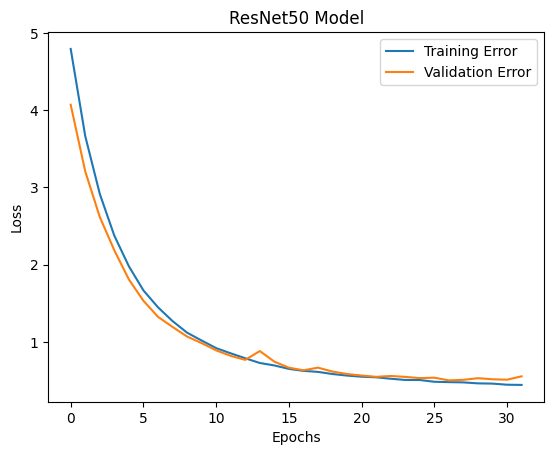

Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 317s 895ms/step - accuracy: 0.6364 - loss: 5.3275 - val_accuracy: 0.8249 - val_loss: 4.0326
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 308s 878ms/step - accuracy: 0.8177 - loss: 3.8376 - val_accuracy: 0.8516 - val_loss: 3.1558
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 313s 891ms/step - accuracy: 0.8316 - loss: 3.0421 - val_accuracy: 0.8484 - val_loss: 2.5539
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 309s 881ms/step - accuracy: 0.8498 - loss: 2.4340 - val_accuracy: 0.8623 - val_loss: 2.0871
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 310s 885ms/step - accuracy: 0.8573 - loss: 2.0102 - val_accuracy: 0.8442 - val_loss: 1.7820
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 309s 880ms/step - accuracy: 0.8519 - loss: 1.6999 - val_accuracy: 0.8609 - val_loss: 1.4897
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 310s 883ms/step - accuracy: 0.8561 - loss: 1.4502 - val_accuracy: 0.8609 - val_loss: 1.3156
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 312s 888ms/step - accuracy: 0.8640 -

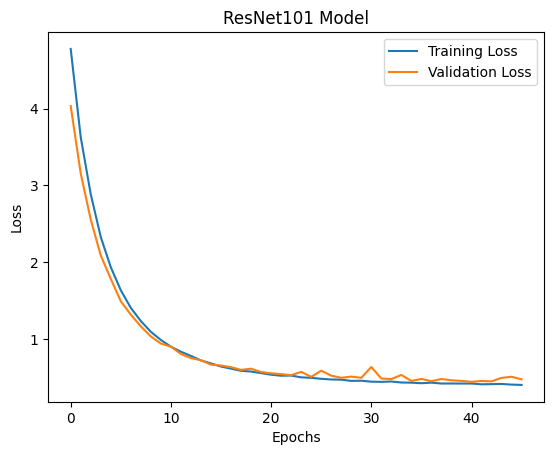

Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 99s 276ms/step - accuracy: 0.2810 - loss: 6.0985 - val_accuracy: 0.4422 - val_loss: 5.2357
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 94s 268ms/step - accuracy: 0.3927 - loss: 5.2345 - val_accuracy: 0.4583 - val_loss: 4.7067
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 99s 282ms/step - accuracy: 0.4218 - loss: 4.7393 - val_accuracy: 0.4815 - val_loss: 4.2816
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 99s 281ms/step - accuracy: 0.4424 - loss: 4.3307 - val_accuracy: 0.5107 - val_loss: 3.8959
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 97s 275ms/step - accuracy: 0.4540 - loss: 3.9572 - val_accuracy: 0.5178 - val_loss: 3.6004
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 97s 278ms/step - accuracy: 0.4523 - loss: 3.6905 - val_accuracy: 0.5025 - val_loss: 3.3427
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 96s 274ms/step - accuracy: 0.4732 - loss: 3.4070 - val_accuracy: 0.5210 - val_loss: 3.1011
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 95s 271ms/step - accuracy: 0.4781 - loss: 3

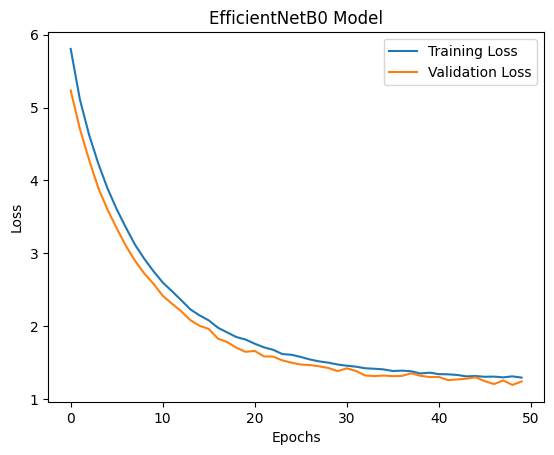

Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 514s 1s/step - accuracy: 0.4670 - loss: 4.7352 - val_accuracy: 0.7578 - val_loss: 3.5113
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 504s 1s/step - accuracy: 0.7498 - loss: 3.4137 - val_accuracy: 0.8060 - val_loss: 2.9187
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 502s 1s/step - accuracy: 0.7864 - loss: 2.8700 - val_accuracy: 0.8288 - val_loss: 2.4685
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 499s 1s/step - accuracy: 0.7918 - loss: 2.4717 - val_accuracy: 0.8313 - val_loss: 2.1522
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 499s 1s/step - accuracy: 0.8173 - loss: 2.1272 - val_accuracy: 0.8384 - val_loss: 1.8791
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 498s 1s/step - accuracy: 0.8209 - loss: 1.8750 - val_accuracy: 0.8538 - val_loss: 1.6594
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 498s 1s/step - accuracy: 0.8295 - loss: 1.6791 - val_accuracy: 0.8381 - val_loss: 1.5141
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 497s 1s/step - accuracy: 0.8225 - loss: 1.5230 - val_accu

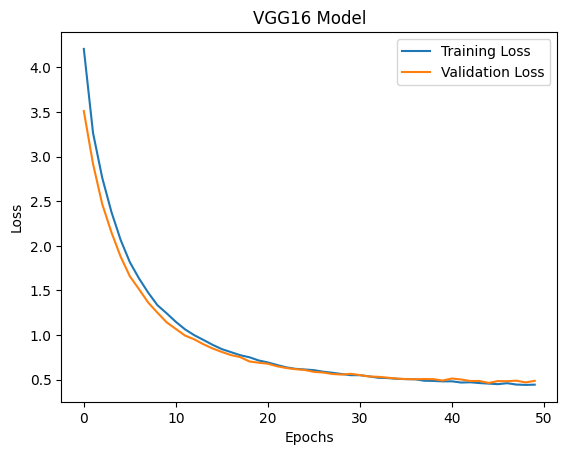

In [6]:
epochs = 50

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = new_resnet50_model.fit(
    train_generator, 
    validation_data=validation_generator, 
    epochs=epochs, 
    callbacks=[early_stopping]
)

plt.title('ResNet50 Model')
plt.plot(history.history['loss'], label='Training Error')
plt.plot(history.history['val_loss'], label='Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

history = new_resnet101_model.fit(
    train_generator, 
    validation_data=validation_generator, 
    epochs=epochs, 
    callbacks=[early_stopping]
)

plt.title('ResNet101 Model')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

history = new_efficientnetb0_model.fit(
    train_generator, 
    validation_data=validation_generator, 
    epochs=epochs, 
    callbacks=[early_stopping]
)

plt.title('EfficientNetB0 Model')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

history = new_vgg16_model.fit(
    train_generator, 
    validation_data=validation_generator, 
    epochs=epochs, 
    callbacks=[early_stopping]
)

plt.title('VGG16 Model')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### v. Report training, validation, and test Precision, Recall, AUC, and F1 score for those models. Is there a model that clearly outperforms others? Remember that this is a multi-class classification problem.

In [17]:
def hot_encode(class_name):
    one_hot = np.zeros(num_classes)
    one_hot[class_name] = 1
    return one_hot

# precision, recall, auc, f1 for each model
training_results = []
validation_results = []
testing_results = []
for model in [new_resnet50_model, new_resnet101_model, new_efficientnetb0_model, new_vgg16_model]:
    # TRAINING
    Y_pred = model.predict(train_generator)
    Y_pred = np.argmax(Y_pred, axis=1) # returns the class
    Y_true = train_generator.classes

    precision = precision_score(Y_true, Y_pred, average='weighted')
    recall = recall_score(Y_true, Y_pred, average='weighted')
    f1 = f1_score(Y_true, Y_pred, average='weighted')

    training_results.append({'model': model, 'precision': precision, 'recall': recall, 'f1': f1})

    # VALIDATION
    Y_pred = model.predict(validation_generator)
    Y_pred = np.argmax(Y_pred, axis=1) # returns the class
    Y_true = validation_generator.classes

    precision = precision_score(Y_true, Y_pred, average='weighted')
    recall = recall_score(Y_true, Y_pred, average='weighted')
    f1 = f1_score(Y_true, Y_pred, average='weighted')

    validation_results.append({'model': model, 'precision': precision, 'recall': recall, 'f1': f1})

    # TESTING
    Y_pred = model.predict(test_generator)
    Y_pred = np.argmax(Y_pred, axis=1) # returns the class
    Y_true = test_generator.classes

    precision = precision_score(Y_true, Y_pred, average='weighted')
    recall = recall_score(Y_true, Y_pred, average='weighted')
    f1 = f1_score(Y_true, Y_pred, average='weighted')

    testing_results.append({'model': model, 'precision': precision, 'recall': recall, 'f1': f1})

training_results_df = pd.DataFrame(training_results)
display(training_results_df)

validation_results_df = pd.DataFrame(validation_results)
display(validation_results_df)

testing_results_df = pd.DataFrame(testing_results)
display(testing_results_df)

351/351 ━━━━━━━━━━━━━━━━━━━━ 135s 384ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 33s 377ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 37s 387ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 240s 683ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 60s 678ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 65s 686ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 71s 202ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 201ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 204ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 436s 1s/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step


,model,precision,recall,f1
0,"<Sequential name=sequential, built=True>",0.168829,0.169101,0.168654
1,"<Sequential name=sequential_1, built=True>",0.168995,0.168566,0.168670
2,"<Sequential name=sequential_2, built=True>",0.164418,0.164203,0.163645
3,"<Sequential name=sequential_3, built=True>",0.162812,0.162778,0.162792


,model,precision,recall,f1
0,"<Sequential name=sequential, built=True>",0.165468,0.165835,0.165416
1,"<Sequential name=sequential_1, built=True>",0.173454,0.173680,0.173375
2,"<Sequential name=sequential_2, built=True>",0.155002,0.154066,0.153554
3,"<Sequential name=sequential_3, built=True>",0.167380,0.167261,0.167306


,model,precision,recall,f1
0,"<Sequential name=sequential, built=True>",0.165301,0.165333,0.164950
1,"<Sequential name=sequential_1, built=True>",0.165115,0.165000,0.164988
2,"<Sequential name=sequential_2, built=True>",0.156551,0.156333,0.155707
3,"<Sequential name=sequential_3, built=True>",0.171684,0.171667,0.171666


The charts above are the Training, Validation, and Test results for ResNet50, ResNet101, EfficientNetB0, and VGG16, respectively. On the Training and Validation sets, ResNet101 seems to have performed the best across the board, but in the Test set, VGG16 performed the best. The differences in the training accuracies is also visible in the charts above.